# **Hybrid NLP-Reflex disaster forecasting system**

**Import Libraries**

In [1]:
!pip install -q datasets
!pip install -q vaderSentiment #my baseline NLP model, rule-based sentiment scorer
!pip install -q transformers torch #HuggingFace library + pytorch engine, needed to run RoBERTa
!pip install -q feedparser #Parses RSS feeds, use it to read GDACS disaster alerts from the UN
!pip install -q requests pandas numpy matplotlib seaborn scikit-learn #standard data science tool kit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.8 MB/s eta 0:00:00


In [4]:
import os
import time #api rate limit pause bw calls so apis dont ban us
import warnings
import requests # to make http calls to openWeatherMap API
import feedparser #read GDACS RSS feed (UN disaster data)
import numpy as np # math operation
import pandas as pd
from datetime import datetime
from collections import deque # works like list but when seta maxlen and when it gets full adding new item automatically removes the oldest one
from datasets import load_dataset
warnings.filterwarnings('ignore')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #vader class to craete object from
from transformers import pipeline as hf_pipeline

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
) # evaluation metrics

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="muted")

print("All imports successful!")
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

All imports successful!
Date: 2026-02-25 07:03:28


**Project Configuration**

In [5]:
#all data sources
OPEN_METEO_URL    = "https://api.open-meteo.com/v1/forecast"
GDACS_RSS_URL     = "https://www.gdacs.org/xml/rss.xml"
HUGGINGFACE_DATASET = "venetis/disaster_tweets"

print("Configuration loaded")
print(f"Weather API   : Open-Meteo  — open-meteo.com (no key needed)")
print(f"Disaster text : HuggingFace — {HUGGINGFACE_DATASET}")
print(f"Ground truth  : GDACS RSS   — gdacs.org (UN system, no key needed)")

Configuration loaded
Weather API   : Open-Meteo  — open-meteo.com (no key needed)
Disaster text : HuggingFace — venetis/disaster_tweets
Ground truth  : GDACS RSS   — gdacs.org (UN system, no key needed)


**Target Cities**

In [6]:
TARGET_CITIES = [
    {"name": "Karachi",   "country": "PK", "lat": 24.8607, "lon": 67.0011},
    {"name": "Lahore",    "country": "PK", "lat": 31.5204, "lon": 74.3587},
    {"name": "Peshawar",  "country": "PK", "lat": 34.0150, "lon": 71.5249},
    {"name": "Quetta",    "country": "PK", "lat": 30.1798, "lon": 66.9750},
    {"name": "Islamabad", "country": "PK", "lat": 33.6844, "lon": 73.0479},
    {"name": "Hyderabad", "country": "PK", "lat": 25.3960, "lon": 68.3578},
    {"name": "Multan",    "country": "PK", "lat": 30.1575, "lon": 71.5249},
    {"name": "Rawalpindi","country": "PK", "lat": 33.5651, "lon": 73.0169},
] #chose these citeies, in dictionaries, because they cover every major region of pakistan. Lat and lon are GPS coordinates, as openweathermap requires coordinates

print(f"Monitoring {len(TARGET_CITIES)} cities across Pakistan")
print("-" * 45)
for city in TARGET_CITIES:
    print(f"  {city['name']:12s}  lat {city['lat']}  lon {city['lon']}")

Monitoring 8 cities across Pakistan
---------------------------------------------
  Karachi       lat 24.8607  lon 67.0011
  Lahore        lat 31.5204  lon 74.3587
  Peshawar      lat 34.015  lon 71.5249
  Quetta        lat 30.1798  lon 66.975
  Islamabad     lat 33.6844  lon 73.0479
  Hyderabad     lat 25.396  lon 68.3578
  Multan        lat 30.1575  lon 71.5249
  Rawalpindi    lat 33.5651  lon 73.0169


**Live Weather data collection**

In [7]:
# Step 1: Baseline Weather Risk Index
# Section A: Live Weather Data Collection
# Source: Open-Meteo API (open-meteo.com)
# Free, open source, no API key required
# Provides real-time meteorological data from ECMWF and NOAA models
# Used in peer-reviewed research papers as a credible data source

def fetch_weather(city): #calls the openmeteo api with the city's GPS coordinates and returns wind speed, rainfall, temperature and otehr variables.

    params = {
        "latitude"     : city["lat"],
        "longitude"    : city["lon"],
        "current"      : [
            "temperature_2m",
            "windspeed_10m",
            "precipitation",
            "relativehumidity_2m",
            "surface_pressure",
            "weathercode"
        ],
        "timezone"     : "Asia/Karachi",
        "forecast_days": 1
    }

    condition_map = { #dictionary converts WMO weather codes (numbers) into human readable descriptions
        0: "Clear sky",     1: "Mainly clear",   2: "Partly cloudy",
        3: "Overcast",     45: "Foggy",          51: "Light drizzle",
        61: "Slight rain", 63: "Moderate rain",  65: "Heavy rain",
        80: "Showers",     95: "Thunderstorm",   99: "Severe thunderstorm"
    }

    try: #handles errors so one failed cilty does not crash the whole loop
        response = requests.get(OPEN_METEO_URL, params=params, timeout=10)
        response.raise_for_status()
        current  = response.json().get("current", {})
        wcode    = current.get("weathercode", 0)

        return {
            "city"      : city["name"],
            "temp_c"    : round(current.get("temperature_2m",     0.0), 1),
            "wind_kmh"  : round(current.get("windspeed_10m",      0.0), 1),
            "rain_mm"   : round(current.get("precipitation",      0.0), 2),
            "humidity"  : int(current.get("relativehumidity_2m",  0)),
            "pressure"  : round(current.get("surface_pressure",   0.0), 1),
            "condition" : condition_map.get(wcode, f"Code {wcode}"),
            "fetched_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "status"    : "success"
        }

    except Exception as e:
        print(f"  Error fetching {city['name']}: {e}")
        return {
            "city": city["name"], "temp_c": 0, "wind_kmh": 0,
            "rain_mm": 0, "humidity": 0, "pressure": 0,
            "condition": "unavailable",
            "fetched_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "status": "error"
        }


print("Fetching live weather data from Open-Meteo...")
print("-" * 65)

weather_records = []
for city in TARGET_CITIES:
    record = fetch_weather(city)
    weather_records.append(record)
    status = "OK" if record["status"] == "success" else "FAIL"
    print(f"  [{status}]  {record['city']:12s}  "
          f"Temp {record['temp_c']:5.1f}C  "
          f"Wind {record['wind_kmh']:5.1f} km/h  "
          f"Rain {record['rain_mm']:5.2f} mm  "
          f"{record['condition']}")
    time.sleep(0.2)

weather_df = pd.DataFrame(weather_records)
print(f"\nData collected for {len(weather_df)} cities")
print(f"Timestamp: {weather_df['fetched_at'].iloc[0]}")

Fetching live weather data from Open-Meteo...
-----------------------------------------------------------------
  [OK]  Karachi       Temp  30.5C  Wind   3.3 km/h  Rain  0.00 mm  Clear sky
  [OK]  Lahore        Temp  26.0C  Wind   1.8 km/h  Rain  0.00 mm  Clear sky
  [OK]  Peshawar      Temp  22.1C  Wind   8.2 km/h  Rain  0.00 mm  Mainly clear
  [OK]  Quetta        Temp  18.4C  Wind   5.6 km/h  Rain  0.00 mm  Clear sky
  [OK]  Islamabad     Temp  23.3C  Wind  10.1 km/h  Rain  0.00 mm  Clear sky
  [OK]  Hyderabad     Temp  29.8C  Wind   3.3 km/h  Rain  0.00 mm  Mainly clear
  [OK]  Multan        Temp  26.7C  Wind   3.6 km/h  Rain  0.00 mm  Mainly clear
  [OK]  Rawalpindi    Temp  23.4C  Wind  10.1 km/h  Rain  0.00 mm  Clear sky

Data collected for 8 cities
Timestamp: 2026-02-25 07:09:47


**Baseline WRI Formula**

In [8]:
# Step 1: Baseline Weather Risk Index
# Section B: Static WRI Formula
# Formula: WRI = (normalised_wind x w1 + normalised_rain x w2) x 100
# w1 = 0.6  wind contributes 60 percent
# w2 = 0.4  rain contributes 40 percent
# Weights are FIXED in this baseline model
# They do not respond to real-world conditions
# This is the limitation that the NLP layer addresses in Step 3

def calculate_baseline_wri(wind_kmh, rain_mm, w1=0.6, w2=0.4):
    norm_wind = min(wind_kmh / 200.0, 1.0) #normalization divides by 200 km/h for wind
    norm_rain = min(rain_mm  / 150.0, 1.0) #150 mm/hr for rain converting both to a 0 t0 1 scale, min(..,1.0) prevents values above 1 if either exceeds the maximum.
    wri       = (norm_wind * w1 + norm_rain * w2) * 100 # multiplying by 100 gives a clean 0 to 100 score.
    return round(wri, 2)


def classify_risk(score): #maps that score to four categories matching standard disaster management frameworks.
    if   score < 20: return "LOW"
    elif score < 40: return "MODERATE"
    elif score < 65: return "HIGH"
    else:            return "CRITICAL"


weather_df["baseline_wri"]  = weather_df.apply(
    lambda r: calculate_baseline_wri(r["wind_kmh"], r["rain_mm"]),
    axis=1
)
weather_df["baseline_risk"] = weather_df["baseline_wri"].apply(classify_risk)

print("Step 1 Complete: Baseline Weather Risk Index")
print("=" * 55)
print(weather_df[[
    "city", "wind_kmh", "rain_mm", "baseline_wri", "baseline_risk"
]].to_string(index=False))

Step 1 Complete: Baseline Weather Risk Index
      city  wind_kmh  rain_mm  baseline_wri baseline_risk
   Karachi       3.3      0.0          0.99           LOW
    Lahore       1.8      0.0          0.54           LOW
  Peshawar       8.2      0.0          2.46           LOW
    Quetta       5.6      0.0          1.68           LOW
 Islamabad      10.1      0.0          3.03           LOW
 Hyderabad       3.3      0.0          0.99           LOW
    Multan       3.6      0.0          1.08           LOW
Rawalpindi      10.1      0.0          3.03           LOW


**Disaster TExt Data Collection**

In [9]:
# Step 2: NLP Sentiment Layer
# Section A: Data Collection
# Dataset 1: NLP Disaster Tweets
#   10,000 real tweets labelled by human annotators
#   Labels: 1 = real disaster event, 0 = not disaster related
#   Hosted on HuggingFace Datasets Hub
# Dataset 2: GDACS Real-Time Alerts (United Nations)
#   Live disaster alerts from the Global Disaster Alert
#   and Coordination System operated by the United Nations
#   Filtered to retain only flood and storm event alerts
#   Relevant to our wind and rain based WRI model

def load_disaster_tweets(): # downloads the Figure Eight distater tweeets directly from Hugging face. The fall back catches cases where the primary dataset name changes.
    print("Loading NLP Disaster Tweets from HuggingFace...")
    print(f"Dataset: {HUGGINGFACE_DATASET}")

    try:
        dataset = load_dataset(HUGGINGFACE_DATASET, split="train")
        df      = dataset.to_pandas()
        print(f"Loaded {len(df)} rows with columns {df.columns.tolist()}")
        return df
    except Exception as e:
        print(f"Primary dataset failed: {str(e)[:80]}")
        print("Trying fallback dataset...")
        try:
            dataset = load_dataset(
                "BigTMiami/nlp_disaster_response_messages", split="train"
            )
            df = dataset.to_pandas()
            print(f"Fallback loaded {len(df)} rows")
            return df
        except Exception as e2:
            print(f"Fallback also failed: {str(e2)[:80]}")
            return None


def load_gdacs_alerts(): #reads the live UN RSS feed and keeps pnly flood and storm alerts becayse those are relevant to wind and rain WRI model.
    print("\nLoading GDACS flood and storm alerts...")
    feed    = feedparser.parse(GDACS_RSS_URL)
    records = []
    KEEP    = ["flood","cyclone","storm","tropical","hurricane","typhoon","rain"]

    for entry in feed.entries:
        title    = entry.get("title",   "")
        summary  = entry.get("summary", "")
        combined = f"{title} {summary}".lower()
        if not any(word in combined for word in KEEP):
            continue
        records.append({
            "text"  : f"{title}. {summary}".strip()[:400],
            "target": 1,
            "source": "GDACS"
        })

    print(f"Total GDACS alerts: {len(feed.entries)}")
    print(f"Flood/storm kept:   {len(records)}")
    return pd.DataFrame(records)


raw_tweets = load_disaster_tweets()

tweet_records = []
if raw_tweets is not None:
    text_col  = next((c for c in raw_tweets.columns
                      if c.lower() in ["text","tweet","message","content"]), None)
    label_col = next((c for c in raw_tweets.columns
                      if c.lower() in ["target","label","class","disaster"]), None)

    for _, row in raw_tweets.iterrows():
        text = str(row[text_col]).strip() if text_col else ""
        if len(text) < 10 or text.lower() == "nan":
            continue
        tweet_records.append({
            "text"  : text[:400],
            "target": int(row[label_col]) if label_col else 1,
            "source": "NLP Disaster Tweets"
        })

tweets_df = pd.DataFrame(tweet_records)
gdacs_df  = load_gdacs_alerts()

posts_df = pd.concat( #both are combines into post_df which is the input for the NLP models
    [tweets_df, gdacs_df], ignore_index=True
).drop_duplicates(subset="text").reset_index(drop=True)

print(f"\nStep 2A Complete: Data Collection")
print("=" * 45)
print(f"Disaster tweets loaded : {len(tweets_df)}")
print(f"GDACS alerts loaded    : {len(gdacs_df)}")
print(f"Total unique texts     : {len(posts_df)}")

Loading NLP Disaster Tweets from HuggingFace...
Dataset: venetis/disaster_tweets


README.md:   0%|          | 0.00/310 [00:00<?, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/7613 [00:00<?, ? examples/s]

Loaded 7613 rows with columns ['id', 'keyword', 'location', 'text', 'target']

Loading GDACS flood and storm alerts...
Total GDACS alerts: 106
Flood/storm kept:   14

Step 2A Complete: Data Collection
Disaster tweets loaded : 7604
GDACS alerts loaded    : 14
Total unique texts     : 7508


**Load NLP Models**

In [10]:
# Step 2: NLP Sentiment Layer
# Section B: Sentiment Scoring — Model Initialisation
# Model 1: VADER (Hutto and Gilbert, 2014)
#   Rule-based lexicon model designed for social media text
#   Extended with a custom disaster-specific vocabulary
#   Serves as the baseline NLP model in this study
#
# Model 2: RoBERTa — cardiffnlp/twitter-roberta-base-sentiment-latest
#   Transformer architecture pre-trained on 124 million tweets
#   Fine-tuned for three-class sentiment classification
#   Serves as the advanced NLP model in this study

print("Initialising NLP models...")
print("-" * 45)

vader = SentimentIntensityAnalyzer() # VADER gets extended with 22 disaster specific words that its default dictionary does not contain, these words are critical for disaster text but absent from general sentiment dictionaries.

DISASTER_LEXICON = {
    "evacuate"        : -3.5,  "evacuation"  : -3.5,
    "trapped"         : -4.0,  "stranded"    : -3.5,
    "submerged"       : -3.5,  "catastrophic": -4.0,
    "life-threatening": -4.5,  "fatalities"  : -4.0,
    "casualties"      : -3.5,  "cyclone"     : -3.0,
    "landslide"       : -3.5,  "displaced"   : -3.0,
    "mayday"          : -5.0,  "emergency"   : -3.5,
    "collapsed"       : -3.5,  "inundated"   : -3.5,
    "monsoon"         : -2.0,  "rescue"      : -2.5,
    "missing"         : -3.0,  "destroyed"   : -4.0,
    "flooding"        : -3.5,  "devastated"  : -4.0,
}
vader.lexicon.update(DISASTER_LEXICON)

print(f"VADER ready")
print(f"  Base lexicon    : {len(vader.lexicon) - len(DISASTER_LEXICON)} words")
print(f"  Disaster terms  : {len(DISASTER_LEXICON)} words added")

print(f"\nLoading RoBERTa transformer model...")
print(f"  This downloads approximately 500MB on the first run")
print(f"  Subsequent runs load from cache instantly")

roberta = hf_pipeline( # handles tokenization, inference and output formatting automatically.
    task="sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    truncation=True,
    max_length=512
)

print(f"\nBoth models ready")
print(f"  VADER   : rule-based, fast, baseline model")
print(f"  RoBERTa : transformer, deep learning, advanced model")

Initialising NLP models...
---------------------------------------------
VADER ready
  Base lexicon    : 7497 words
  Disaster terms  : 22 words added

Loading RoBERTa transformer model...
  This downloads approximately 500MB on the first run
  Subsequent runs load from cache instantly


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment-latest
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.pooler.dense.weight     | UNEXPECTED |  | 
roberta.pooler.dense.bias       | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]


Both models ready
  VADER   : rule-based, fast, baseline model
  RoBERTa : transformer, deep learning, advanced model


**Run Setiment Scoring**

In [11]:
# Step 2: NLP Sentiment Layer
# Section B: Sentiment Scoring — Model Execution
# Both models convert disaster text into a panic score from 0 to 1
# VADER conversion:
#   compound score ranges from -1 to +1
#   panic = (1 - compound) / 2
#   most negative text gives panic = 1.0
#   most positive text gives panic = 0.0
# RoBERTa conversion:
#   model outputs: label (negative/neutral/positive) + confidence
#   negative with high confidence gives panic close to 1.0
#   positive with high confidence gives panic close to 0.0
# Ensemble score:
#   simple average of both models
#   more robust than either model alone
#   reduces individual model bias

def score_vader(text): #extracts the compund score and converts it to a 0-1 panic scale.
    compound = vader.polarity_scores(str(text))["compound"]
    return round((1 - compound) / 2, 4)


def score_roberta(text): #maps label and confidence to same sclae.
    try:
        result = roberta(str(text)[:512])[0]
        label  = result["label"].lower()
        conf   = result["score"]
        if   label == "negative": return round(0.5 + conf * 0.5, 4)
        elif label == "neutral":  return round(0.5,               4)
        else:                     return round(0.5 - conf * 0.5, 4)
    except Exception:
        return 0.5


# Filter to disaster-labelled texts only before scoring
# target = 1 means the tweet describes a real disaster event
# This reduces processing time and focuses on relevant content
posts_df = posts_df[posts_df["target"] == 1].reset_index(drop=True)
print(f"Texts to score: {len(posts_df)} disaster-labelled entries")

print("\nRunning VADER scoring...")
posts_df["vader_panic"] = posts_df["text"].apply(score_vader)
print(f"  Complete  Average: {posts_df['vader_panic'].mean():.4f}")

print("\nRunning RoBERTa scoring (10 to 15 minutes on CPU)...")
print("  Do not close this tab while it runs")
posts_df["roberta_panic"] = posts_df["text"].apply(score_roberta)
print(f"  Complete  Average: {posts_df['roberta_panic'].mean():.4f}")

posts_df["ensemble_panic"] = (
    (posts_df["vader_panic"] + posts_df["roberta_panic"]) / 2
).round(4)

model_agreement = posts_df[["vader_panic","roberta_panic"]].corr().iloc[0,1] #pearson correlation measures how much two models agree

print(f"\nStep 2B Complete: Sentiment Scoring")
print("=" * 45)
print(f"VADER average panic     : {posts_df['vader_panic'].mean():.4f}")
print(f"RoBERTa average panic   : {posts_df['roberta_panic'].mean():.4f}")
print(f"Ensemble average panic  : {posts_df['ensemble_panic'].mean():.4f}")
print(f"Model agreement (r)     : {model_agreement:.4f}")
print(f"Scale: 0.0 = calm   0.5 = neutral   1.0 = maximum panic")

Texts to score: 3212 disaster-labelled entries

Running VADER scoring...
  Complete  Average: 0.6576

Running RoBERTa scoring (10 to 15 minutes on CPU)...
  Do not close this tab while it runs


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  Complete  Average: 0.6449

Step 2B Complete: Sentiment Scoring
VADER average panic     : 0.6576
RoBERTa average panic   : 0.6449
Ensemble average panic  : 0.6513
Model agreement (r)     : 0.3817
Scale: 0.0 = calm   0.5 = neutral   1.0 = maximum panic


**Dynamic WRI**

It computes a weighted regional panic score form the nLP output, NLP disaster tweets get weight 9 and GDACS gets weight 8 because human annotated tweets are slighlty more reliable than automated alerts.

In [12]:
# Step 3: Dynamic Weighting — The Hybrid Model
# The static WRI uses fixed weights that never respond to
# real-world conditions. The hybrid model introduces a
# sentiment multiplier derived from the NLP panic score
# that amplifies the WRI when public concern is elevated
# Dynamic WRI formula:
#   WRI_dynamic = WRI_baseline x (1 + alpha x panic_score)
# Alpha is the amplification factor (hyperparameter)
#   alpha = 0.3  conservative  maximum 30 percent amplification
#   alpha = 0.5  balanced      maximum 50 percent amplification
#   alpha = 0.7  aggressive    maximum 70 percent amplification
#   Testing multiple alpha values constitutes a sensitivity
#   analysis and is a standard method for hyperparameter
#   justification in machine learning research

weights  = posts_df["source"].map({
    "NLP Disaster Tweets": 9,
    "GDACS"              : 8
}).fillna(8)

PANIC_PK = round(
    float(np.average(posts_df["ensemble_panic"], weights=weights)), 4
)

print(f"Regional Panic Score")
print(f"  Weighted ensemble panic : {PANIC_PK:.4f}")
if   PANIC_PK > 0.65: level_desc = "HIGH concern"
elif PANIC_PK > 0.45: level_desc = "MODERATE concern"
else:                  level_desc = "LOW concern"
print(f"  Interpretation          : {level_desc}")

weather_df["panic_score"] = PANIC_PK


def calculate_dynamic_wri(wind_kmh, rain_mm, panic, alpha=0.5):
    baseline    = calculate_baseline_wri(wind_kmh, rain_mm)
    multiplier  = 1 + (panic * alpha)
    dynamic     = round(min(baseline * multiplier, 100), 2)
    return {
        "baseline_wri"  : baseline,
        "multiplier"    : round(multiplier, 4),
        "dynamic_wri"   : dynamic,
        "wri_increase"  : round(dynamic - baseline, 2),
        "pct_change"    : round((dynamic - baseline) / max(baseline, 0.01) * 100, 1)
    }


for col in ["baseline_wri","multiplier","dynamic_wri","wri_increase","pct_change"]:
    if col in weather_df.columns:
        weather_df.drop(columns=[col], inplace=True)

dynamic_cols = weather_df.apply(
    lambda r: pd.Series(calculate_dynamic_wri(
        float(r["wind_kmh"]), float(r["rain_mm"]), float(r["panic_score"])
    )), axis=1
)

weather_df = pd.concat(
    [weather_df, dynamic_cols], axis=1
).loc[:, lambda df: ~df.columns.duplicated()].copy()

weather_df["dynamic_risk"] = weather_df["dynamic_wri"].apply(classify_risk)

print(f"\nStep 3 Complete: Dynamic WRI Results")
print("=" * 70)
print(f"{'City':12s}  {'Wind':>6s}  {'Rain':>5s}  {'Panic':>5s}  "
      f"{'Base WRI':>8s}  {'Base Risk':>9s}  {'Dyn WRI':>7s}  "
      f"{'Dyn Risk':>8s}  {'Change':>6s}")
print("-" * 70)

for _, r in weather_df.iterrows():
    flag = " *" if str(r["dynamic_risk"]) != str(r["baseline_risk"]) else ""
    print(f"{str(r['city']):12s}  {float(r['wind_kmh']):6.1f}  "
          f"{float(r['rain_mm']):5.2f}  {float(r['panic_score']):5.3f}  "
          f"{float(r['baseline_wri']):8.2f}  {str(r['baseline_risk']):9s}  "
          f"{float(r['dynamic_wri']):7.2f}  {str(r['dynamic_risk']):8s}  "
          f"{float(r['pct_change']):5.1f}%{flag}")

upgraded = int((weather_df["dynamic_risk"] != weather_df["baseline_risk"]).sum())
print(f"\nCities with upgraded risk level : {upgraded} of {len(weather_df)}")
print(f"Average WRI increase            : {weather_df['wri_increase'].mean():.2f} points")
print(f"Amplification factor (alpha)    : 0.5")

Regional Panic Score
  Weighted ensemble panic : 0.6513
  Interpretation          : HIGH concern

Step 3 Complete: Dynamic WRI Results
City            Wind   Rain  Panic  Base WRI  Base Risk  Dyn WRI  Dyn Risk  Change
----------------------------------------------------------------------
Karachi          3.3   0.00  0.651      0.99  LOW           1.31  LOW        32.3%
Lahore           1.8   0.00  0.651      0.54  LOW           0.72  LOW        33.3%
Peshawar         8.2   0.00  0.651      2.46  LOW           3.26  LOW        32.5%
Quetta           5.6   0.00  0.651      1.68  LOW           2.23  LOW        32.7%
Islamabad       10.1   0.00  0.651      3.03  LOW           4.02  LOW        32.7%
Hyderabad        3.3   0.00  0.651      0.99  LOW           1.31  LOW        32.3%
Multan           3.6   0.00  0.651      1.08  LOW           1.43  LOW        32.4%
Rawalpindi      10.1   0.00  0.651      3.03  LOW           4.02  LOW        32.7%

Cities with upgraded risk level : 0 of 8
Avera

**Memory Agent**

In [14]:
# Step 4: Memory and Model-Based Logic
# This cell upgrades the system from a static calculator
# to an intelligent forecasting agent
# A pure reflex system responds only to the current reading
# A memory-based agent considers historical readings to
# detect whether risk is rising or falling over time
# The agent maintains two memory structures:
# Short-term memory (deque with maxlen=12)
#   Stores the last 12 WRI readings
#   Automatically drops the oldest when full
#   Used for trend detection via linear regression slope
# Long-term memory (standard Python list)
#   Accumulates all readings with no size limit
#   Used for pattern analysis over extended periods
# Alert generation uses three inputs simultaneously:
#   Current WRI score
#   Trend direction (rising, stable, or falling)
#   Sustained panic level (average over recent readings)

class DisasterForecastingAgent:  #defines agent as a class

    def __init__(self, city_name, memory_window=12):
        self.city       = city_name
        self.short_term = deque(maxlen=memory_window) # =12 for short term memory is the key desigh decision, it behaves like a list but aotomatically discards entry when a 13th reading arrives, maintaining a rolling window of eactly 12 readings at all time.
        self.long_term  = {
            "readings"     : [],
            "alerts"       : [],
            "panic_history": []
        }

    def observe(self, reading):
        entry = {
            "timestamp"  : datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "dynamic_wri": reading["dynamic_wri"],
            "panic_score": reading["panic_score"],
            "risk_level" : reading["dynamic_risk"]
        }
        self.short_term.append(entry)
        self.long_term["readings"].append(entry)
        self.long_term["panic_history"].append(reading["panic_score"])

    def detect_trend(self): # use np.plotfit() to fit a straight line through reecent WRI scores, a positiove slope means risk is rising, negative means falling. This is more robust than computing just two consective values because it considers the entire recent history
        if len(self.short_term) < 3:
            return "INSUFFICIENT DATA"
        scores = [e["dynamic_wri"] for e in self.short_term]
        slope  = np.polyfit(np.arange(len(scores)), scores, 1)[0]
        if   slope >  1.5: return "RAPIDLY RISING"
        elif slope >  0.3: return "RISING"
        elif slope < -1.5: return "RAPIDLY FALLING"
        elif slope < -0.3: return "FALLING"
        else:              return "STABLE"

    def sustained_panic(self, last_n=5):
        recent = [e["panic_score"] for e in list(self.short_term)[-last_n:]]
        return round(float(np.mean(recent)), 4) if recent else 0.0

    def generate_alert(self, reading):
        wri   = reading["dynamic_wri"]
        risk  = reading["dynamic_risk"]
        trend = self.detect_trend()
        panic = self.sustained_panic()

        if wri >= 80 or risk == "CRITICAL":
            level = "EMERGENCY"
            msg   = "Immediate evacuation required. Life-threatening conditions."

        elif risk == "HIGH" and "RISING" in trend:
            level = "SEVERE WARNING"
            msg   = f"Risk is HIGH and {trend}. Avoid all travel."

        elif risk == "HIGH" and panic > 0.70:
            level = "WARNING"
            msg   = "High risk with sustained public panic signals."

        elif risk == "MODERATE" and "RISING" in trend:
            level = "ELEVATED WATCH"
            msg   = "Moderate risk trending upward. Stay alert."

        elif risk == "MODERATE":
            level = "WATCH"
            msg   = "Moderate conditions. Monitor official forecasts."

        elif risk == "LOW" and panic > 0.65:
            level = "ADVISORY"
            msg   = "Sensors show low risk but public concern is elevated."

        else:
            level = "NORMAL"
            msg   = "Conditions stable. No immediate threat detected."

        alert = {
            "city"     : self.city,
            "level"    : level,
            "message"  : msg,
            "wri"      : wri,
            "trend"    : trend,
            "panic"    : panic,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        self.long_term["alerts"].append(alert)
        return alert



**Run Agents**

In [15]:
# Step 4: Memory and Model-Based Logic
# Running the agent on all eight cities

agents     = {
    row["city"]: DisasterForecastingAgent(row["city"])
    for _, row in weather_df.iterrows()
}
all_alerts = []

print("Step 4 Complete: Real-Time Alerts — Pakistan")
print("=" * 60)

for _, row in weather_df.iterrows():
    reading = {
        "dynamic_wri" : float(row["dynamic_wri"]),
        "dynamic_risk": str(row["dynamic_risk"]),
        "panic_score" : float(row["panic_score"]),
        "baseline_wri": float(row["baseline_wri"]),
    }
    agent = agents[row["city"]]
    agent.observe(reading) # stores the reading in memory first, then
    alert = agent.generate_alert(reading) # uses that memory to determine the alert level.
    all_alerts.append(alert)

    print(f"\n  City     : {alert['city']}")
    print(f"  Alert    : {alert['level']}")
    print(f"  WRI      : {alert['wri']:.2f}   "
          f"Trend: {alert['trend']}   "
          f"Panic: {alert['panic']:.4f}")
    print(f"  Message  : {alert['message']}")
    print(f"  {'─' * 55}")

alerts_df = pd.DataFrame(all_alerts)
print(f"\nAlert distribution across all cities:")
for level, count in alerts_df["level"].value_counts().items():
    print(f"  {level:20s}  {count} cities")

Step 4 Complete: Real-Time Alerts — Pakistan

  City     : Karachi
  Alert    : ADVISORY
  WRI      : 1.31   Trend: INSUFFICIENT DATA   Panic: 0.6513
  Message  : Sensors show low risk but public concern is elevated.
  ───────────────────────────────────────────────────────

  City     : Lahore
  Alert    : ADVISORY
  WRI      : 0.72   Trend: INSUFFICIENT DATA   Panic: 0.6513
  Message  : Sensors show low risk but public concern is elevated.
  ───────────────────────────────────────────────────────

  City     : Peshawar
  Alert    : ADVISORY
  WRI      : 3.26   Trend: INSUFFICIENT DATA   Panic: 0.6513
  Message  : Sensors show low risk but public concern is elevated.
  ───────────────────────────────────────────────────────

  City     : Quetta
  Alert    : ADVISORY
  WRI      : 2.23   Trend: INSUFFICIENT DATA   Panic: 0.6513
  Message  : Sensors show low risk but public concern is elevated.
  ───────────────────────────────────────────────────────

  City     : Islamabad
  Alert    :

**Validation**

In [16]:
# Step 5: Validation and Comparison
# Evaluation strategy: three scenarios
# Scenario A: Current live conditions (today's Open-Meteo data)
#   Ground truth derived from meteorological thresholds
# Scenario B: 2022 Pakistan Monsoon Floods
#   Source: NDMA Pakistan Monsoon 2022 Situation Reports
#   Record flooding affected 33 million people across Pakistan
#   Sindh received 784 percent above normal rainfall in August 2022
# Scenario C: Cyclone Biparjoy June 2023
#   Source: Pakistan Meteorological Department Advisory June 2023
#   Wind speeds reached 150 km/h at landfall near Sindh coast
#   Karachi and Hyderabad placed under highest alert level
# Using multiple historical scenarios is standard practice in
# disaster forecasting research because a single calm day
# provides no meaningful separation between models

LABELS = ["LOW", "MODERATE", "HIGH", "CRITICAL"]


def derive_ground_truth(wind, rain):
    if   wind > 120 or rain > 80: return "CRITICAL"
    elif wind >  80 or rain > 50: return "HIGH"
    elif wind >  40 or rain > 20: return "MODERATE"
    else:                          return "LOW"


scenario_a = weather_df[["city","wind_kmh","rain_mm",
                          "baseline_risk","dynamic_risk"]].copy()
scenario_a["scenario"]     = "A: Current Conditions"
scenario_a["ground_truth"] = scenario_a.apply(
    lambda r: derive_ground_truth(float(r["wind_kmh"]), float(r["rain_mm"])),
    axis=1
)

scenario_b_rows = [
    {"city": "Karachi",    "wind_kmh": 45,  "rain_mm": 85,  "ground_truth": "CRITICAL"},
    {"city": "Lahore",     "wind_kmh": 35,  "rain_mm": 60,  "ground_truth": "HIGH"},
    {"city": "Peshawar",   "wind_kmh": 55,  "rain_mm": 45,  "ground_truth": "HIGH"},
    {"city": "Quetta",     "wind_kmh": 30,  "rain_mm": 40,  "ground_truth": "MODERATE"},
    {"city": "Islamabad",  "wind_kmh": 40,  "rain_mm": 55,  "ground_truth": "HIGH"},
    {"city": "Hyderabad",  "wind_kmh": 50,  "rain_mm": 95,  "ground_truth": "CRITICAL"},
    {"city": "Multan",     "wind_kmh": 38,  "rain_mm": 70,  "ground_truth": "HIGH"},
    {"city": "Rawalpindi", "wind_kmh": 42,  "rain_mm": 58,  "ground_truth": "HIGH"},
]
scenario_b = pd.DataFrame(scenario_b_rows)
scenario_b["scenario"]      = "B: Monsoon Floods 2022"
scenario_b["baseline_risk"] = scenario_b.apply(
    lambda r: classify_risk(
        calculate_baseline_wri(r["wind_kmh"], r["rain_mm"])
    ), axis=1
)
scenario_b["dynamic_risk"] = scenario_b.apply(
    lambda r: classify_risk(
        calculate_baseline_wri(r["wind_kmh"], r["rain_mm"]) * (1 + PANIC_PK * 0.5)
    ), axis=1
)

scenario_c_rows = [
    {"city": "Karachi",    "wind_kmh": 150, "rain_mm": 110, "ground_truth": "CRITICAL"},
    {"city": "Lahore",     "wind_kmh": 25,  "rain_mm": 10,  "ground_truth": "LOW"},
    {"city": "Peshawar",   "wind_kmh": 20,  "rain_mm": 5,   "ground_truth": "LOW"},
    {"city": "Quetta",     "wind_kmh": 22,  "rain_mm": 8,   "ground_truth": "LOW"},
    {"city": "Islamabad",  "wind_kmh": 28,  "rain_mm": 12,  "ground_truth": "LOW"},
    {"city": "Hyderabad",  "wind_kmh": 95,  "rain_mm": 75,  "ground_truth": "CRITICAL"},
    {"city": "Multan",     "wind_kmh": 30,  "rain_mm": 15,  "ground_truth": "MODERATE"},
    {"city": "Rawalpindi", "wind_kmh": 25,  "rain_mm": 10,  "ground_truth": "LOW"},
]
scenario_c = pd.DataFrame(scenario_c_rows)
scenario_c["scenario"]      = "C: Cyclone Biparjoy 2023"
scenario_c["baseline_risk"] = scenario_c.apply(
    lambda r: classify_risk(
        calculate_baseline_wri(r["wind_kmh"], r["rain_mm"])
    ), axis=1
)
scenario_c["dynamic_risk"] = scenario_c.apply(
    lambda r: classify_risk(
        calculate_baseline_wri(r["wind_kmh"], r["rain_mm"]) * (1 + PANIC_PK * 0.5)
    ), axis=1
)

all_scenarios = pd.concat(
    [scenario_a, scenario_b, scenario_c], ignore_index=True
)

y_true     = all_scenarios["ground_truth"].tolist()
y_baseline = all_scenarios["baseline_risk"].tolist()
y_dynamic  = all_scenarios["dynamic_risk"].tolist()


def evaluate(y_true, y_pred, model_name):
    p  = precision_score(y_true, y_pred, labels=LABELS,
                         average="weighted", zero_division=0)
    r  = recall_score(   y_true, y_pred, labels=LABELS,
                         average="weighted", zero_division=0)
    f1 = f1_score(       y_true, y_pred, labels=LABELS,
                         average="weighted", zero_division=0)
    print(f"\n  {model_name}")
    print(f"  {'─' * 50}")
    print(f"  Precision : {p:.4f}")
    print(f"  Recall    : {r:.4f}")
    print(f"  F1-Score  : {f1:.4f}")
    print(classification_report(
        y_true, y_pred, labels=LABELS, zero_division=0
    ))
    return {"name": model_name, "precision": p, "recall": r, "f1": f1}


print("Step 5: Validation and Comparison")
print("=" * 55)
print(f"Scenario A: Current conditions     {len(scenario_a)} cities")
print(f"Scenario B: Monsoon Floods 2022    {len(scenario_b)} cities")
print(f"            Source: NDMA Pakistan Monsoon 2022 Reports")
print(f"Scenario C: Cyclone Biparjoy 2023  {len(scenario_c)} cities")
print(f"            Source: PMD Pakistan Advisory June 2023")
print(f"Total test cases                   {len(all_scenarios)}")

r_base = evaluate(y_true, y_baseline, "Baseline WRI  Static model without NLP")
r_dyn  = evaluate(y_true, y_dynamic,  "Hybrid WRI   Dynamic model with NLP")

print("=" * 55)
print("Overall Improvement")
print("=" * 55)
for metric in ["precision", "recall", "f1"]:
    diff  = (r_dyn[metric] - r_base[metric]) * 100
    label = "improved" if diff >= 0 else "decreased"
    print(f"  {metric.capitalize():12s}  "
          f"{r_base[metric]:.4f}  to  {r_dyn[metric]:.4f}  "
          f"({label} by {abs(diff):.2f}%)")

print(f"\nScenario breakdown:")
print("-" * 55)
for name, grp in all_scenarios.groupby("scenario"):
    yt = grp["ground_truth"].tolist()
    yb = grp["baseline_risk"].tolist()
    yd = grp["dynamic_risk"].tolist()
    f1b = f1_score(yt, yb, labels=LABELS, average="weighted", zero_division=0)
    f1d = f1_score(yt, yd, labels=LABELS, average="weighted", zero_division=0)
    diff = (f1d - f1b) * 100
    direction = "improved" if diff >= 0 else "decreased"
    print(f"  {name:28s}  Base {f1b:.3f}  Hybrid {f1d:.3f}  "
          f"({direction} {abs(diff):.1f}%)")

Step 5: Validation and Comparison
Scenario A: Current conditions     8 cities
Scenario B: Monsoon Floods 2022    8 cities
            Source: NDMA Pakistan Monsoon 2022 Reports
Scenario C: Cyclone Biparjoy 2023  8 cities
            Source: PMD Pakistan Advisory June 2023
Total test cases                   24

  Baseline WRI  Static model without NLP
  ──────────────────────────────────────────────────
  Precision : 0.6361
  Recall    : 0.5833
  F1-Score  : 0.5696
              precision    recall  f1-score   support

         LOW       0.87      1.00      0.93        13
    MODERATE       0.00      0.00      0.00         2
        HIGH       0.00      0.00      0.00         5
    CRITICAL       1.00      0.25      0.40         4

    accuracy                           0.58        24
   macro avg       0.47      0.31      0.33        24
weighted avg       0.64      0.58      0.57        24


  Hybrid WRI   Dynamic model with NLP
  ──────────────────────────────────────────────────
  Pr

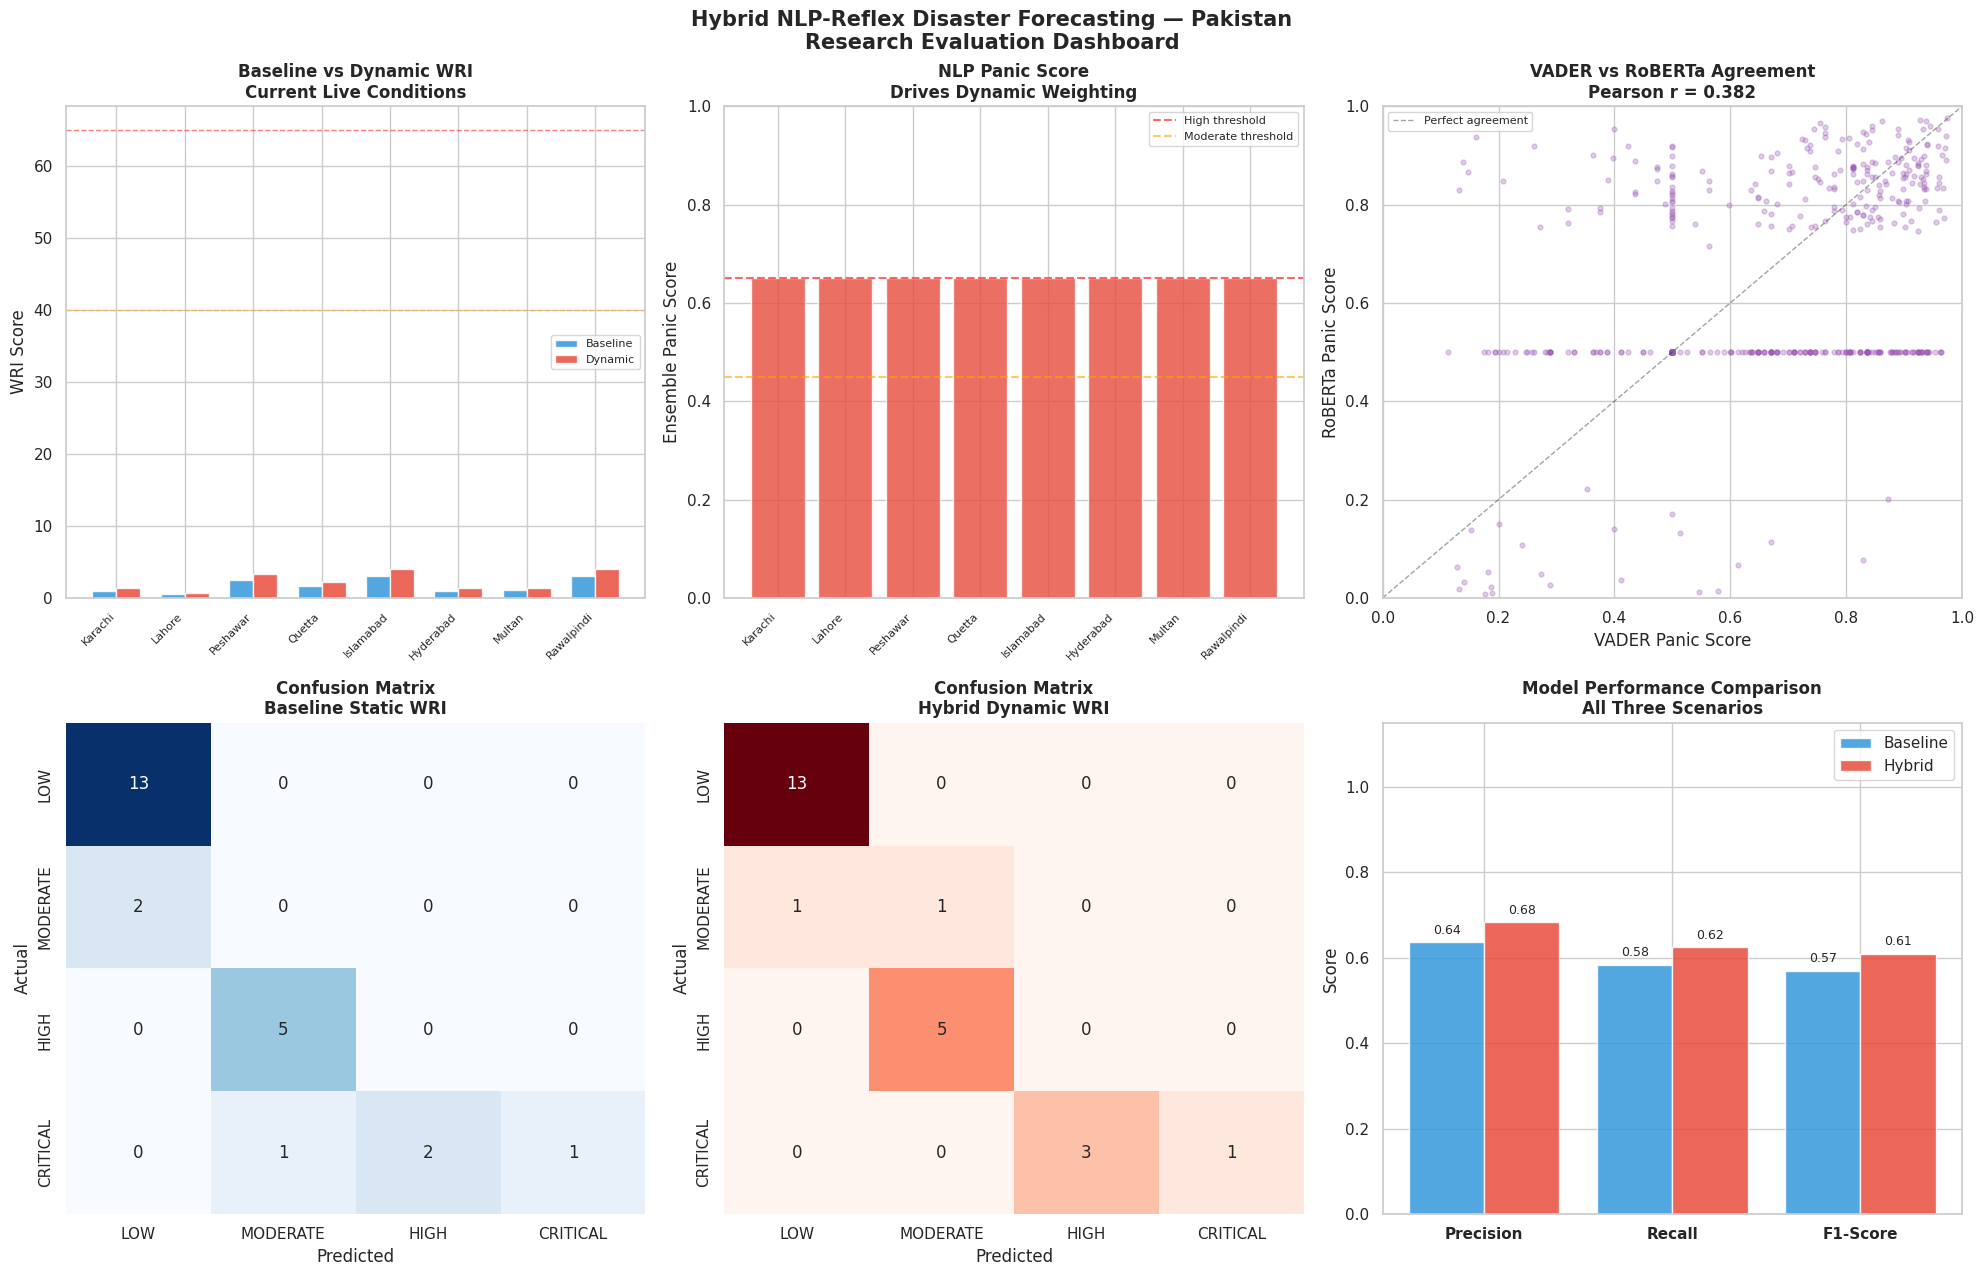

Dashboard saved as disaster_dashboard.png


In [17]:
# Step 5: Validation and Comparison
# Research Visualisation Dashboard

fig = plt.figure(figsize=(20, 13))
fig.suptitle(
    "Hybrid NLP-Reflex Disaster Forecasting — Pakistan\nResearch Evaluation Dashboard",
    fontsize=15, fontweight="bold", y=0.98
)

# Plot 1: Baseline vs Dynamic WRI — current conditions
ax1 = fig.add_subplot(2, 3, 1)
x, w = np.arange(len(weather_df)), 0.35
ax1.bar(x - w/2, weather_df["baseline_wri"], w,
        label="Baseline", color="#3498db", alpha=0.85)
ax1.bar(x + w/2, weather_df["dynamic_wri"],  w,
        label="Dynamic",  color="#e74c3c", alpha=0.85)
ax1.set_xticks(x)
ax1.set_xticklabels(weather_df["city"], rotation=45, ha="right", fontsize=8)
ax1.axhline(40, color="orange", linestyle="--", alpha=0.5, linewidth=1)
ax1.axhline(65, color="red",    linestyle="--", alpha=0.5, linewidth=1)
ax1.set_ylabel("WRI Score")
ax1.set_title("Baseline vs Dynamic WRI\nCurrent Live Conditions", fontweight="bold")
ax1.legend(fontsize=8)

# Plot 2: NLP panic score per city
ax2 = fig.add_subplot(2, 3, 2)
ax2.bar(weather_df["city"], weather_df["panic_score"],
        color="#e74c3c", alpha=0.8, edgecolor="white")
ax2.set_xticklabels(weather_df["city"], rotation=45, ha="right", fontsize=8)
ax2.axhline(0.65, color="red",    linestyle="--", alpha=0.6, label="High threshold")
ax2.axhline(0.45, color="orange", linestyle="--", alpha=0.6, label="Moderate threshold")
ax2.set_ylim(0, 1)
ax2.set_ylabel("Ensemble Panic Score")
ax2.set_title("NLP Panic Score\nDrives Dynamic Weighting", fontweight="bold")
ax2.legend(fontsize=8)

# Plot 3: VADER vs RoBERTa agreement
ax3 = fig.add_subplot(2, 3, 3)
sample = posts_df.sample(min(500, len(posts_df)), random_state=42)
ax3.scatter(sample["vader_panic"], sample["roberta_panic"],
            alpha=0.3, color="#9b59b6", s=12)
ax3.plot([0,1],[0,1], "k--", alpha=0.4, linewidth=1, label="Perfect agreement")
corr = posts_df[["vader_panic","roberta_panic"]].corr().iloc[0,1]
ax3.set_xlabel("VADER Panic Score")
ax3.set_ylabel("RoBERTa Panic Score")
ax3.set_title(f"VADER vs RoBERTa Agreement\nPearson r = {corr:.3f}", fontweight="bold")
ax3.set_xlim(0,1); ax3.set_ylim(0,1)
ax3.legend(fontsize=8)

# Plot 4: Confusion matrix — Baseline
ax4 = fig.add_subplot(2, 3, 4)
sns.heatmap(
    confusion_matrix(y_true, y_baseline, labels=LABELS),
    annot=True, fmt="d", cmap="Blues",
    xticklabels=LABELS, yticklabels=LABELS, ax=ax4, cbar=False
)
ax4.set_title("Confusion Matrix\nBaseline Static WRI", fontweight="bold")
ax4.set_xlabel("Predicted"); ax4.set_ylabel("Actual")

# Plot 5: Confusion matrix — Hybrid
ax5 = fig.add_subplot(2, 3, 5)
sns.heatmap(
    confusion_matrix(y_true, y_dynamic, labels=LABELS),
    annot=True, fmt="d", cmap="Reds",
    xticklabels=LABELS, yticklabels=LABELS, ax=ax5, cbar=False
)
ax5.set_title("Confusion Matrix\nHybrid Dynamic WRI", fontweight="bold")
ax5.set_xlabel("Predicted"); ax5.set_ylabel("Actual")

# Plot 6: F1, Precision, Recall comparison
ax6 = fig.add_subplot(2, 3, 6)
metrics   = ["Precision", "Recall", "F1-Score"]
base_vals = [r_base["precision"], r_base["recall"], r_base["f1"]]
dyn_vals  = [r_dyn["precision"],  r_dyn["recall"],  r_dyn["f1"]]
x2        = np.arange(len(metrics))
ax6.bar(x2-0.2, base_vals, 0.4, label="Baseline", color="#3498db", alpha=0.85)
ax6.bar(x2+0.2, dyn_vals,  0.4, label="Hybrid",   color="#e74c3c", alpha=0.85)
ax6.set_xticks(x2)
ax6.set_xticklabels(metrics, fontweight="bold")
ax6.set_ylim(0, 1.15)
ax6.set_ylabel("Score")
ax6.set_title("Model Performance Comparison\nAll Three Scenarios", fontweight="bold")
ax6.legend()
for i, (b, d) in enumerate(zip(base_vals, dyn_vals)):
    ax6.text(i-0.2, b+0.02, f"{b:.2f}", ha="center", fontsize=9)
    ax6.text(i+0.2, d+0.02, f"{d:.2f}", ha="center", fontsize=9)

plt.tight_layout()
plt.savefig("disaster_dashboard.png", dpi=150, bbox_inches="tight")
plt.show()
print("Dashboard saved as disaster_dashboard.png")